In [52]:
import os
import numpy as np
from pathlib import Path
import seaborn as sns
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

fd = Path('/home/bohdan/studies/sem8/mpr/mpr/lab2')
os.chdir(fd)

In [169]:
def create_measurements_df(scaling_type, size):
    data = {}    
    for file in fd.iterdir():
        fname = file.name
        if fname.startswith(scaling_type) and fname.endswith(size):
            ncores = fname.split('_')[1]
            m = np.fromfile(fname, dtype=np.float16, sep='\n')
            m = m[(m >= np.quantile(m, .1)) & (m <= np.quantile(m, .9))]
            data[ncores] = m
    
    
    
    return pd.DataFrame({k: pd.Series(v) for k,v in sorted(data.items(), key=lambda i: int(i[0])) })



def calculate_speedup(time_df: pd.DataFrame):
    speedup = pd.DataFrame()
    for n_threads in time_df.columns:
        speedup[n_threads] = time_df['1'] / time_df[n_threads]
    return speedup

def calculate_efficiency(speedup_df: pd.DataFrame):
    efficiency = pd.DataFrame()
    for n_threads in speedup_df.columns:
        efficiency[n_threads] = speedup_df[n_threads] / int(n_threads)
    return efficiency

def calculate_serial_fraction(speedup_df: pd.DataFrame):
    serial_fraction = pd.DataFrame()
    for n_threads in speedup_df.columns:
        n = int(n_threads)
        if n == 1:
            continue
        numerator = (1 / speedup_df[n_threads] - 1 / n)
        denominator = (1 - 1 / n)
        serial_fraction[n_threads] = numerator / denominator
    return serial_fraction


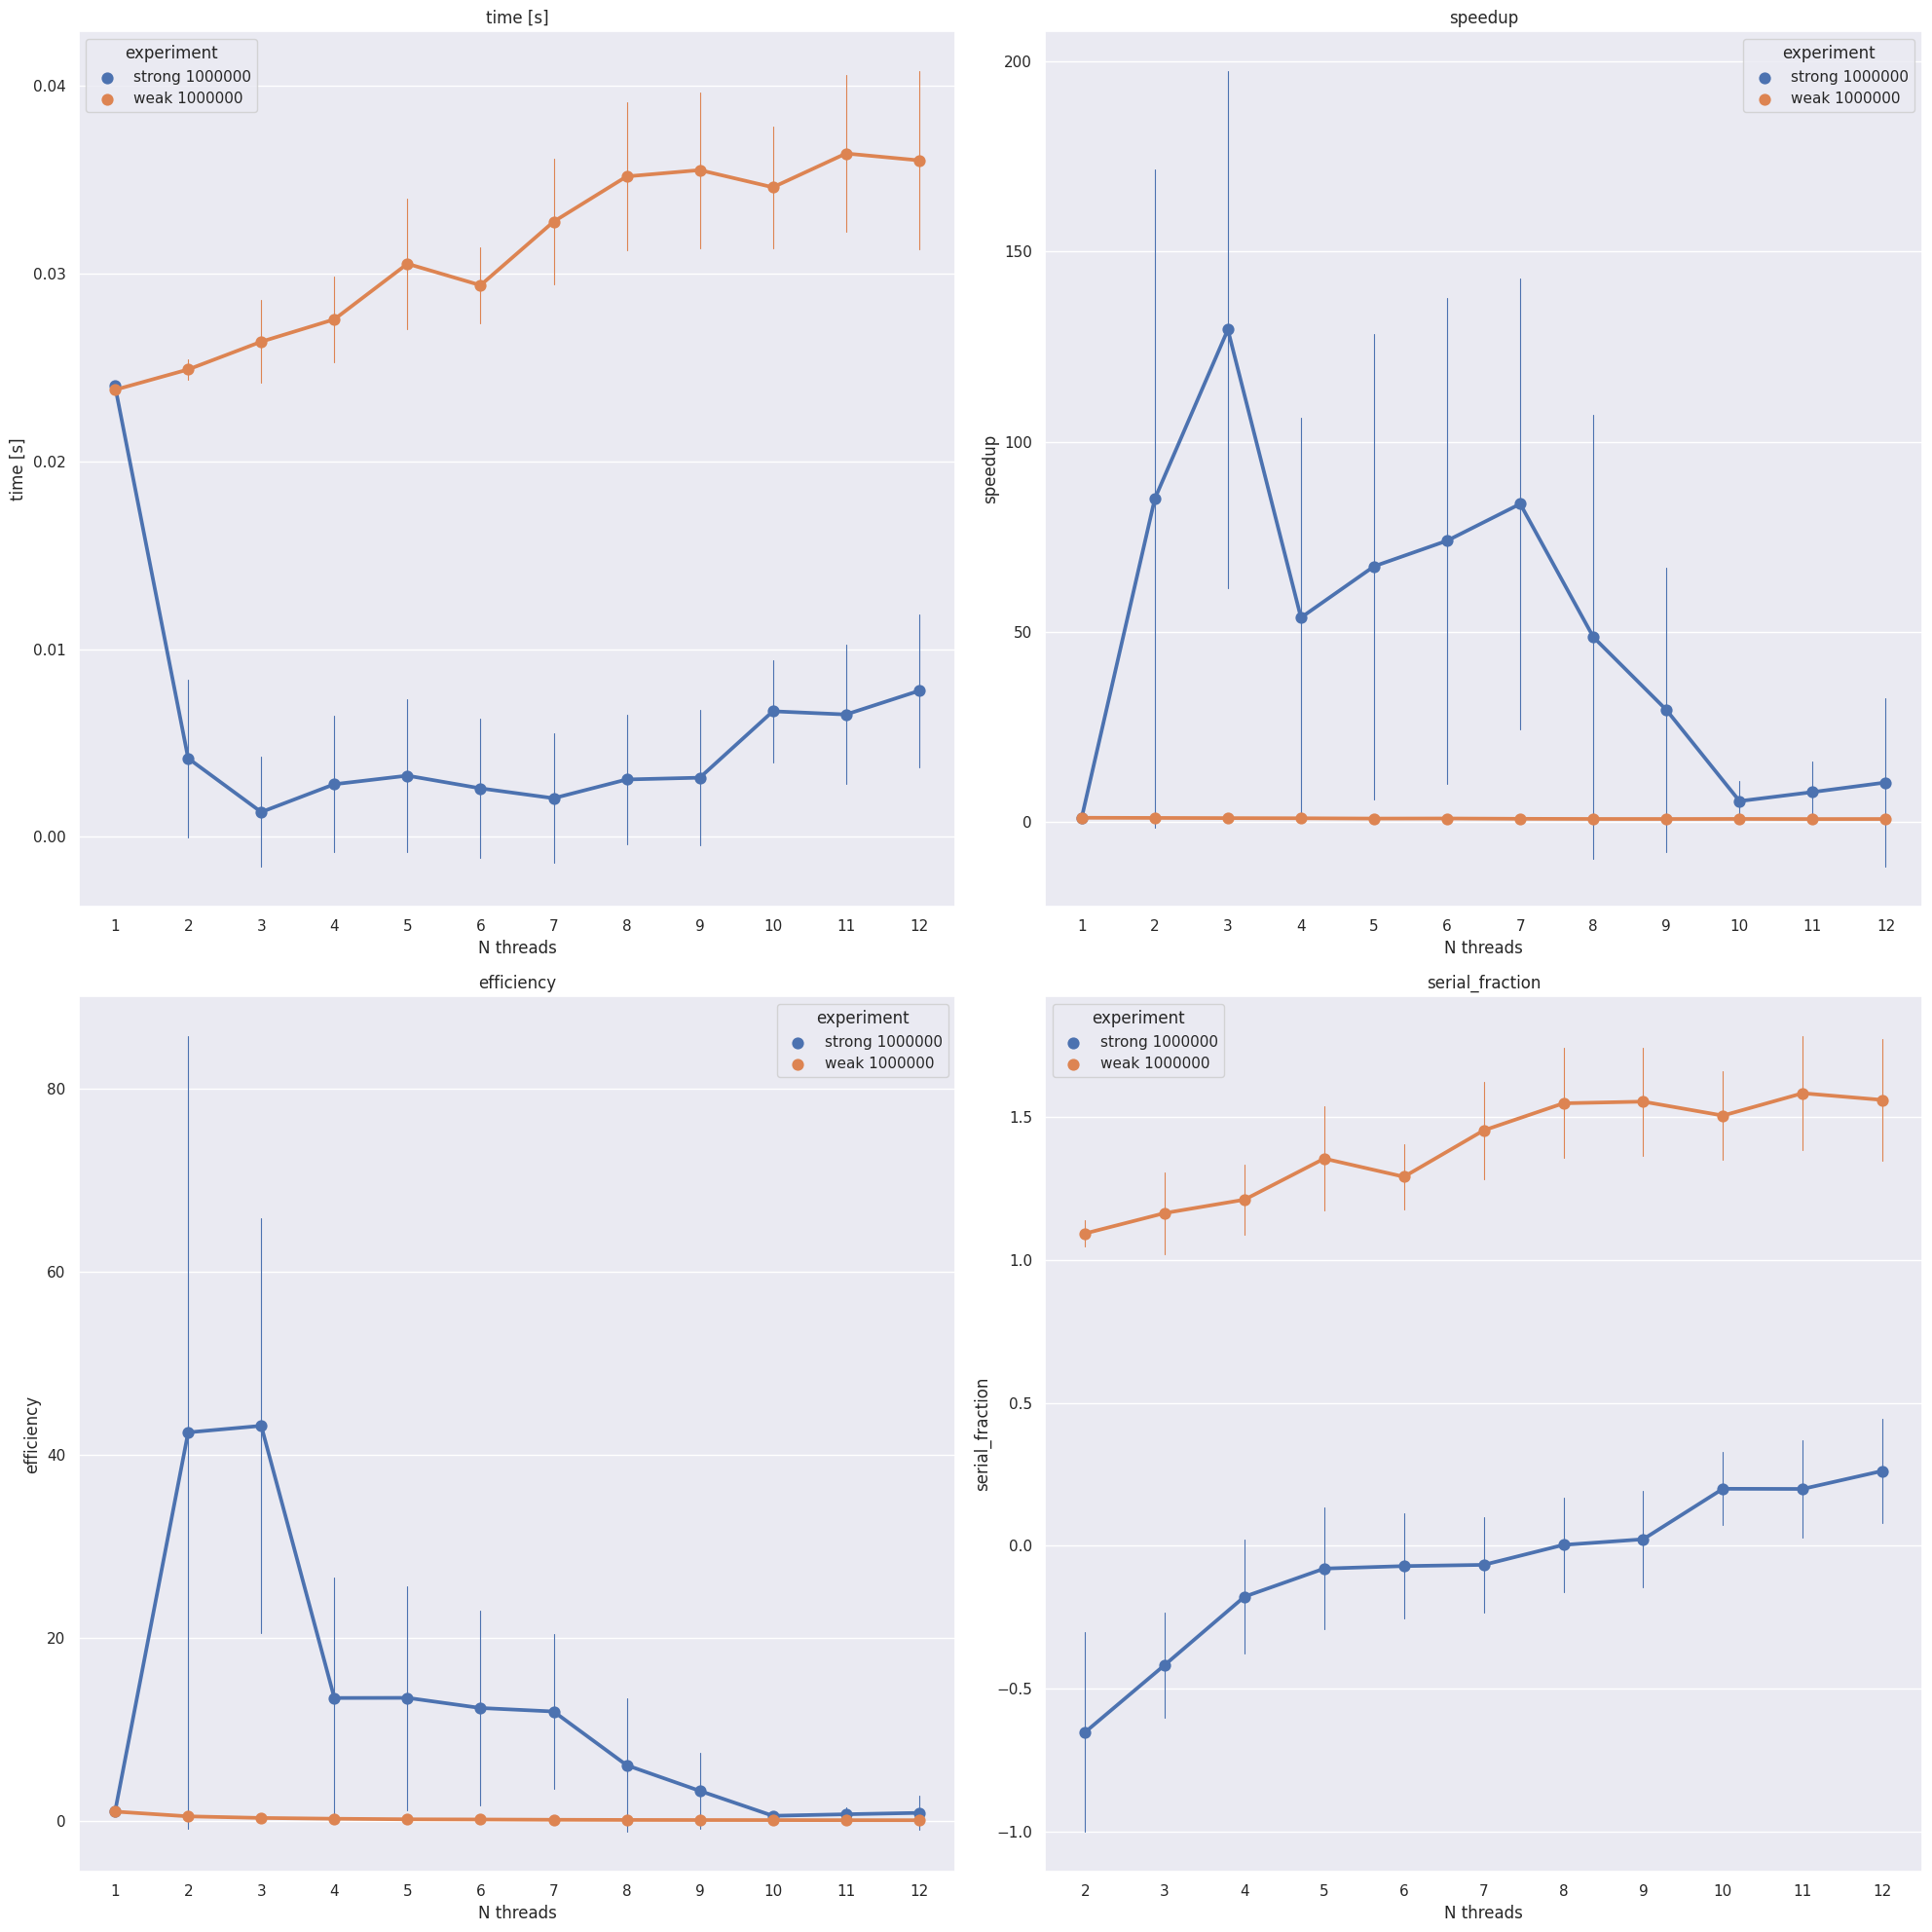

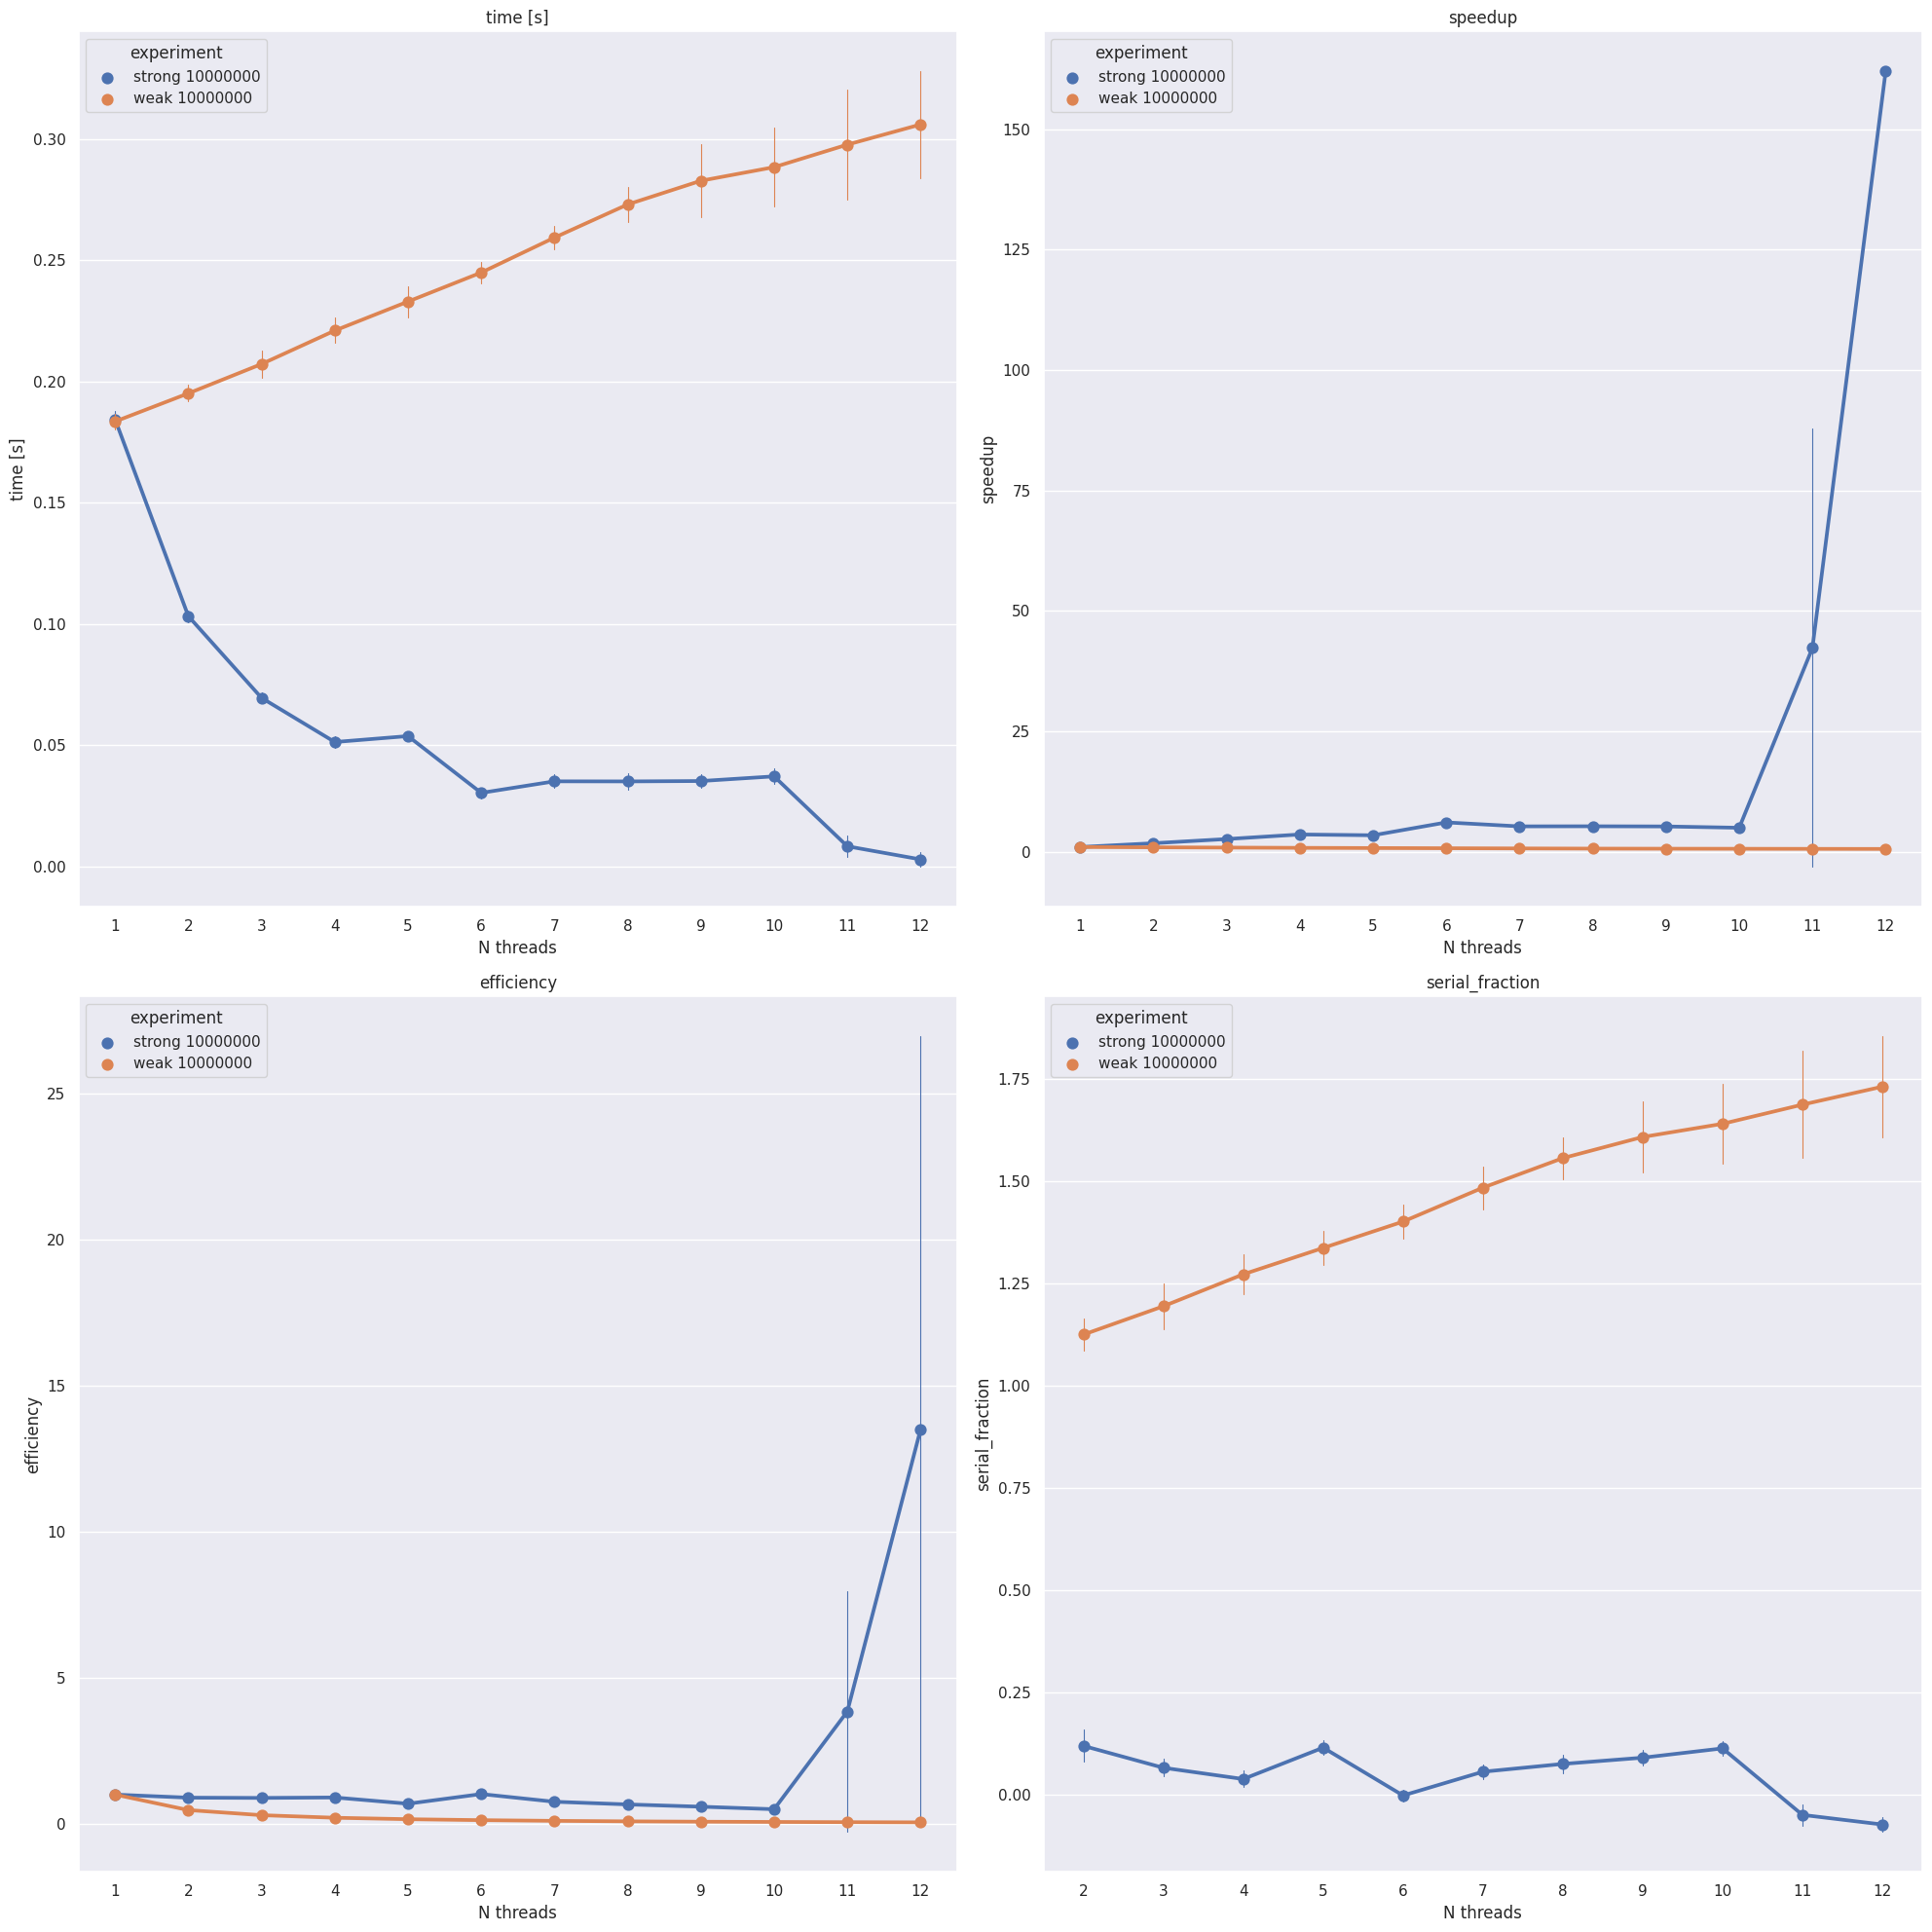

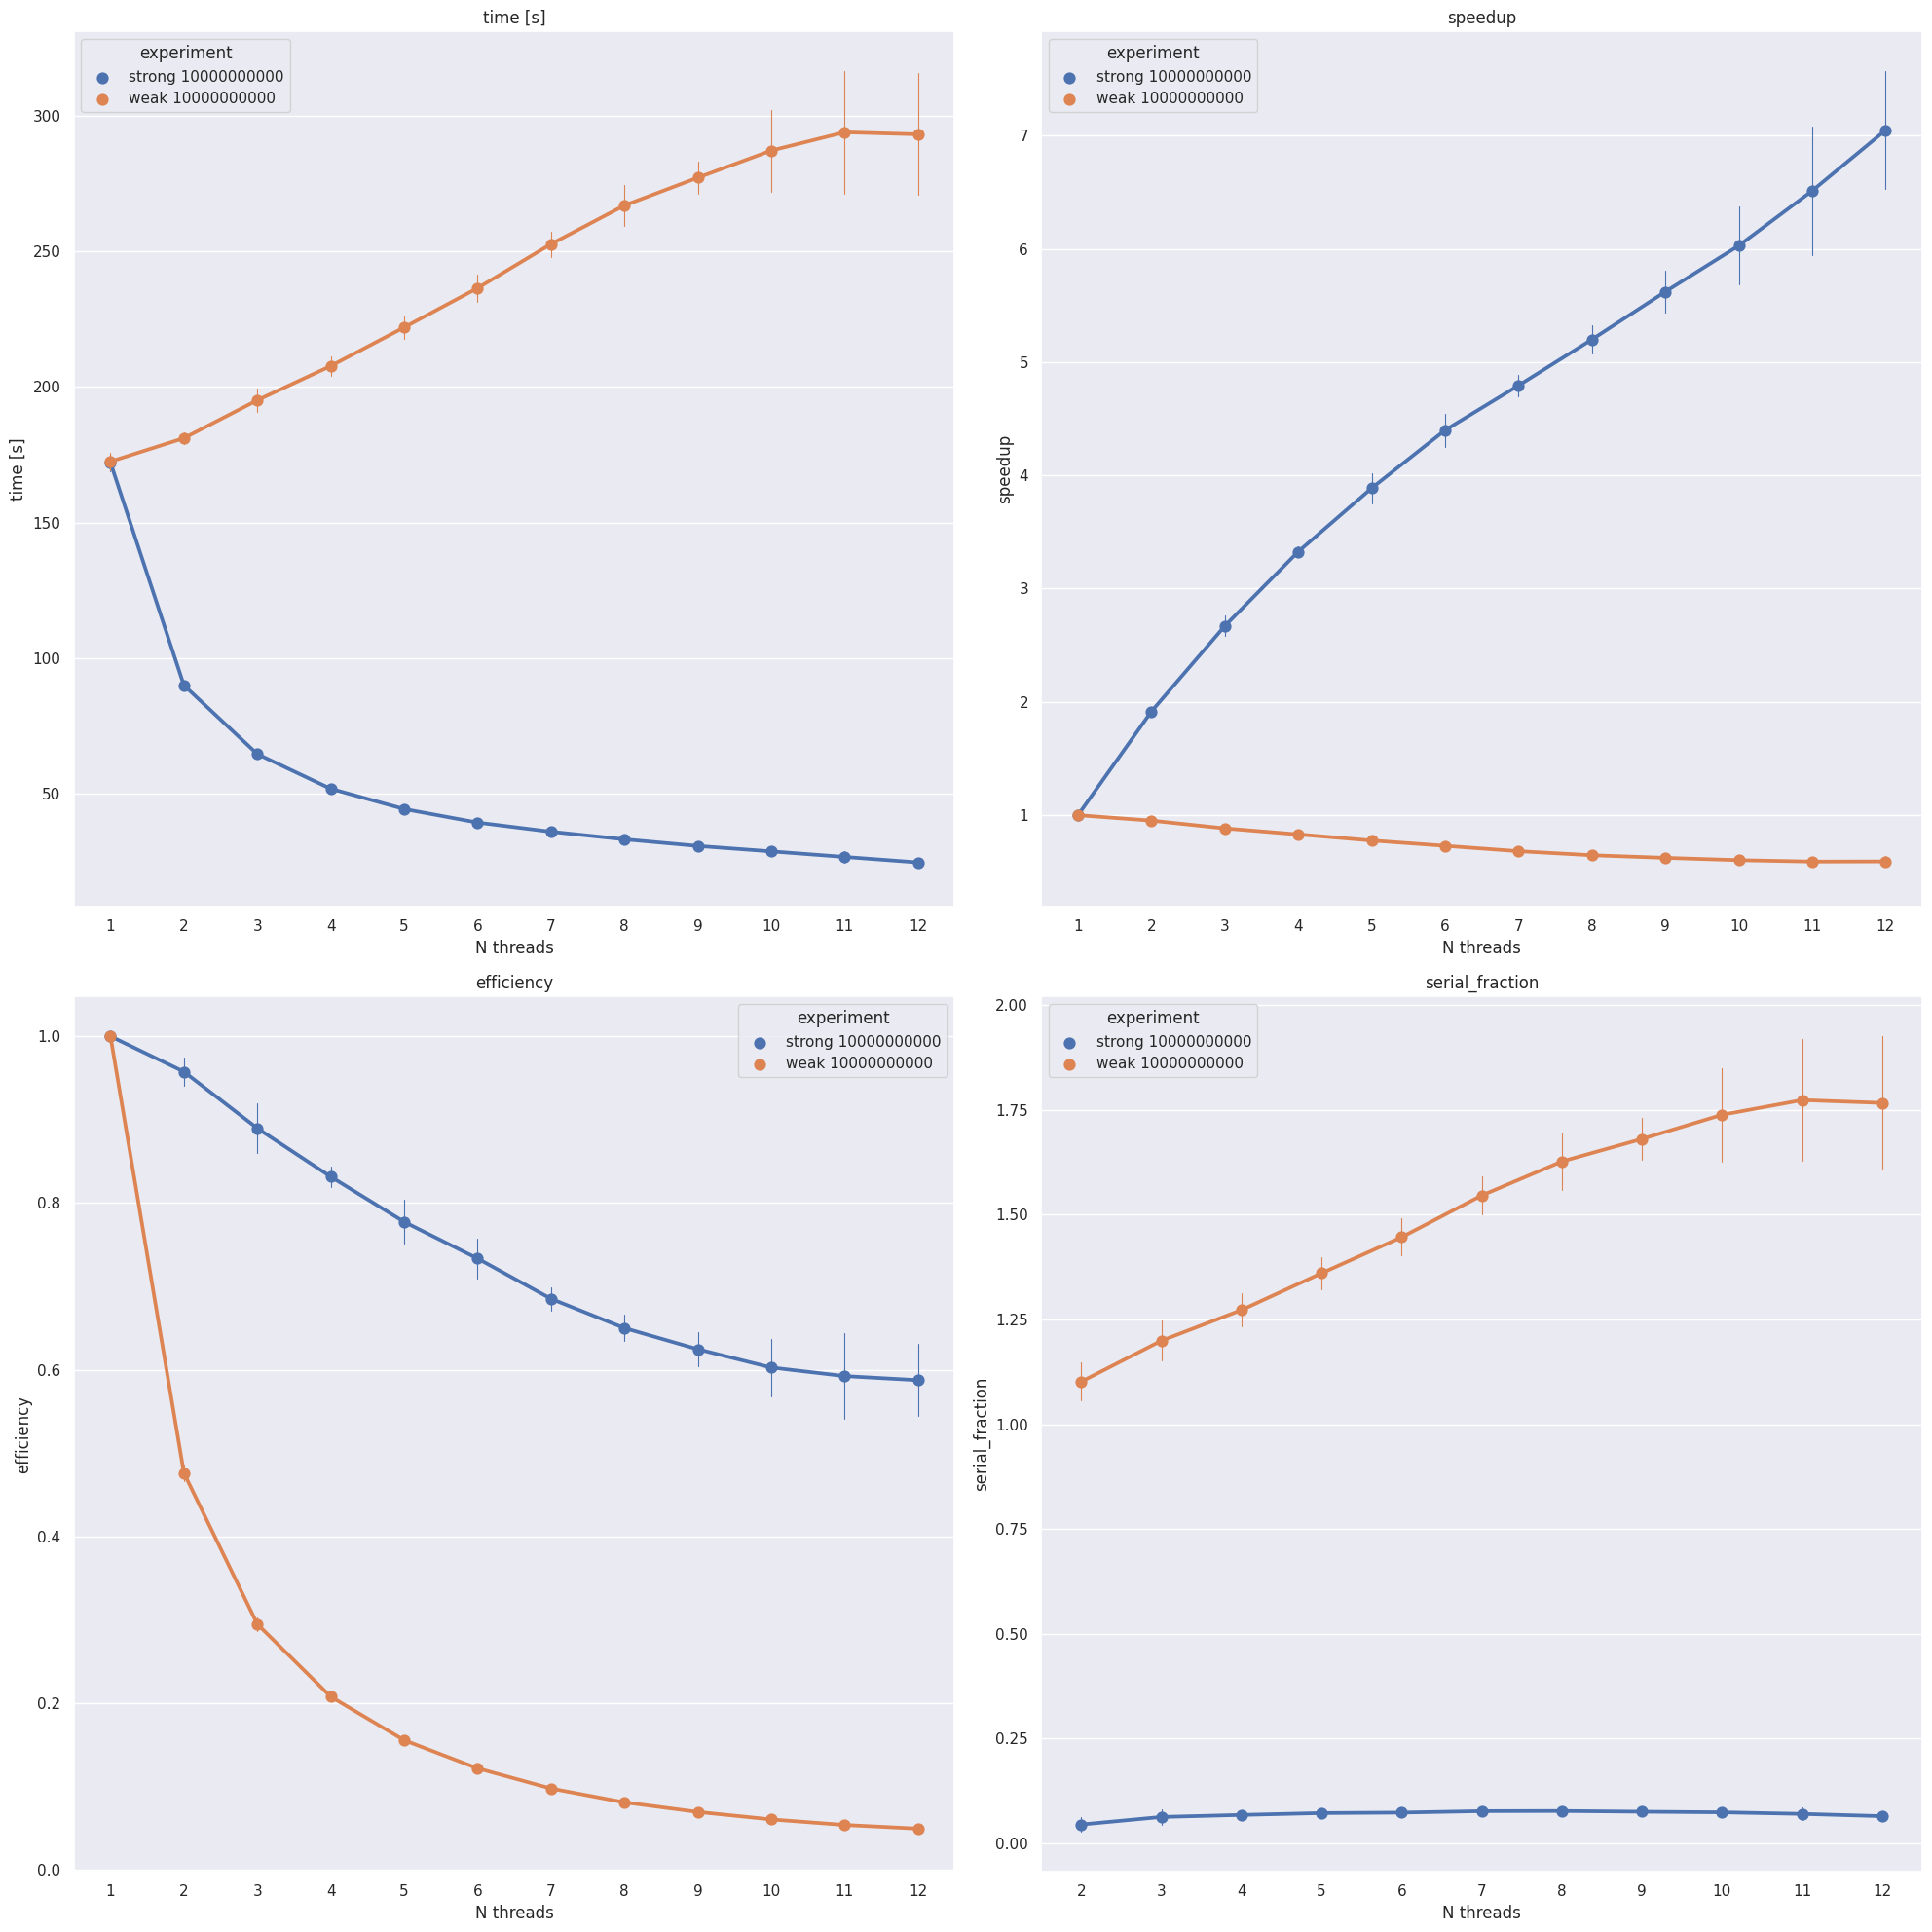

In [179]:
from typing import cast


def create_long_dfs(scaling, size):
    time = create_measurements_df(scaling, size)
    speedup = calculate_speedup(time)
    efficiency = calculate_efficiency(speedup)
    serial_fraction = calculate_serial_fraction(speedup)
    metrics = [
        {
            'title': 'time [s]',
            'df': time,
        },
        {
            'title': 'speedup',
            'df': speedup,
        },
        {
            'title': 'efficiency',
            'df': efficiency,
        },
        {
            'title': 'serial_fraction',
            'df': serial_fraction,
        }
    ]    
    for metric in metrics:
        df = metric['df'].melt(value_name=metric['title'], var_name='N threads')
        df = cast(pd.DataFrame, df)
        df['experiment'] = f'{scaling} {size.removesuffix(".0")}'
        metric['df'] = df
    return [m['df'] for m in metrics]

def get_ideal_lambda(metric, scaling):
    return {k['title']:k['ideal_lambda'] for k in [
        {
            'title': 'time [s]',
            'ideal_lambda': lambda n: 1 / n if scaling == 'strong' else 1
        },
        {
            'title': 'speedup',
            'ideal_lambda': lambda n: 1 if scaling == 'strong' else 1 / n
        },
        {
            'title': 'efficiency',
            'ideal_lambda': lambda n: 1
        },
        {
            'title': 'serial_fraction',
            'ideal_lambda': lambda n: 0
        }
    ]}[metric]
    

for size in ['1000000.0', '10000000.0', '30000000000.0']:
    sns.set_theme()
    metric_dfs = [pd.DataFrame() for _ in range(4)]
    fig, axs = plt.subplots(2, 2, figsize=(20, 20), tight_layout=True)
    axs = np.array(axs).flatten()
    for scaling in ['strong', 'weak']:
        longs_dfs = create_long_dfs(scaling, size)
        for i in range(4):
            metric_dfs[i] = pd.concat([metric_dfs[i], longs_dfs[i]], axis=0)
    
    for df, ax, title in zip(metric_dfs, axs, ['time [s]', 'speedup', 'efficiency', 'serial_fraction']):
        ax = sns.pointplot(
            data = df
            , x = 'N threads'
            , y = title
            , hue = 'experiment'
            , ax = ax
            # , showfliers=False
            , estimator='mean'
            , errorbar='sd'
            , errwidth=.8
            # , xlabel='N threads'
            )
        ax.set_title(title)
        # if title == 'time [s]':
            # continue
        # for scaling in ['strong', 'weak']:
        #     ideal_lambda = get_ideal_lambda(title, scaling)
        #     xs = range(1, 13)
        #     ax.plot(xs, [ideal_lambda(x) for x in xs], linestyle='--', marker='o', label=f'Ideal {title} for {scaling}')